# Assignment 4 - Clustering reviews

In [1]:
import pandas as pd
import sklearn
import numpy
import matplotlib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
from time import time

from sklearn import metrics
numpy.random.seed(0)

# Task 1 - Data Exploration and Preprocessing

## Manual look at the data
Some items start end with quotes this is automatically handled by pandas.reader_csv

When looking at the data we can see there are items for animals (cat/dog threads) Food for humans, drinks for humans, positive reviews, negative reviews this can all be possible clusters

In [2]:
reviews = pd.read_csv("reviews.csv")
reviews

,Id,Summary,Text
0,1,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
1,2,great kitty treats,My cat loves these treats. If ever I can't fin...
2,3,COFFEE TASTE,A little less than I expected. It tends to ha...
3,4,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
4,5,Great Taste . . .,and I want to congratulate the graphic artist ...
...,...,...,...
9995,9996,"Frame is great, rest is flimsy - Thankfully th...","The frame of this is what holds the weight, an..."
9996,9997,Pleasantly suprised,I ordered this kit just to try it since the pr...
9997,9998,Super coffee,This espresso is amazing. My wife would not dr...
9998,9999,Sweet!,I was so happy when I decided to look for Runt...


Some items have HTML tags inside them

In [3]:
reviews.loc[reviews['Id'] == 5366]

,Id,Summary,Text
5365,5366,satisfying hot or cold,"<span class=""tiny""> Length:: 2:06 Mins<br /><b..."


In [4]:
reviews.loc[reviews['Text'].str.contains("<span class=\"tiny\">", na=False)]

,Id,Summary,Text
833,834,Tasty Treat Should Be Enjoyed Carefully,"<span class=""tiny""> Length:: 5:41 Mins<br /><b..."
2942,2943,Pink Lemonade: possibly best flavored Emergen-...,"<span class=""tiny""> Length:: 1:11 Mins<br /><b..."
5365,5366,satisfying hot or cold,"<span class=""tiny""> Length:: 2:06 Mins<br /><b..."
7901,7902,"and in not-so-blind taste testing, our consume...","<span class=""tiny""> Length:: 1:39 Mins<br /><b..."
8321,8322,Dented in Shipping,"<span class=""tiny""> Length:: 0:46 Mins<br /><b..."
8338,8339,"Mango & pineapple are nice, but delicioso on ice","<span class=""tiny""> Length:: 4:38 Mins<br /><b..."
8883,8884,Potentially messy but my dog loves it.,"<span class=""tiny""> Length:: 1:01 Mins<br /><b..."


,Id,Summary,Text
833,834,Tasty Treat Should Be Enjoyed Carefully,"<span class=""tiny""> Length:: 5:41 Mins<br /><b..."
2942,2943,Pink Lemonade: possibly best flavored Emergen-...,"<span class=""tiny""> Length:: 1:11 Mins<br /><b..."
5365,5366,satisfying hot or cold,"<span class=""tiny""> Length:: 2:06 Mins<br /><b..."
7901,7902,"and in not-so-blind taste testing, our consume...","<span class=""tiny""> Length:: 1:39 Mins<br /><b..."
8321,8322,Dented in Shipping,"<span class=""tiny""> Length:: 0:46 Mins<br /><b..."
8338,8339,"Mango & pineapple are nice, but delicioso on ice","<span class=""tiny""> Length:: 4:38 Mins<br /><b..."
8883,8884,Potentially messy but my dog loves it.,"<span class=""tiny""> Length:: 1:01 Mins<br /><b..."


In [5]:
reviews.loc[reviews['Summary'].str.contains("<", na=False)]

,Id,Summary,Text


In [6]:
from bs4 import BeautifulSoup

def to_clean_text(html):
    soup = BeautifulSoup(html)

    for span in soup.find_all("span", class_="tiny"):
        span.decompose()  # This removes the tag from the soup

    return soup.get_text()

print("items with < and in name before", len(reviews.loc[reviews['Text'].str.contains("<", na=False)]))

reviews['Text'] = reviews["Text"].apply(to_clean_text)
print("items with < and in name after", len(reviews.loc[reviews['Text'].str.contains("<", na=False)]))

reviews.loc[reviews['Text'].str.contains("<", na=False)]

items with < and in name before 2573
items with < and in name after 12


,Id,Summary,Text
213,214,Farmers Organic Canned Pumpkin EXCELLENT PRODUCT,I've purchased the Farmers Organic canned Pump...
428,429,Way overpriced; only average taste,Always on the lookout for a new coffee adventu...
447,448,Food actually went bad.,"I get this item today (7/16/2012), tried two b..."
636,637,I'm a very conflicted individual...,Just smelling this bottle makes my toes curl i...
1396,1397,not good for chewers,I got this for my 60lb boxer mix as a replacem...
1506,1507,Delicious chocolate way to get 14grams of fibe...,"These Chocoperfection bars taste so good, you'..."
3385,3386,"Too expensive, but VERY convenient",This lasts forever on the shelf or in the refe...
5042,5043,Honey graham cracker goodness!,"I've always loved graham crackers, they are on..."
5158,5159,"Great tasting, balanced protein & fat, LOW pho...","My cat just love them, chomping down the kibbl..."
7086,7087,PopChips have ruined other chips for me!,I <3 Popchips...maybe a little TOO much! I wa...


## Different encoding methods

### bag-of-words with stopwords and lemmatizer

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import WordNetLemmatizer

nltk.download("all")
lemmatizer = WordNetLemmatizer()
def to_clean_text(sentence):
    # Tokenize the sentence into words
    words = word_tokenize(sentence)
    stop_words = set(stopwords.words("english"))

    filtered_sentence = [word for word in words if word.lower() not in stop_words]
    lemmatized_sentence = [lemmatizer.lemmatize(word, "v") for word in filtered_sentence]
    final_sentence = " ".join(lemmatized_sentence)
    return final_sentence

reviews['Cleaned_text'] = reviews["Text"].apply(to_clean_text)
reviews

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/steen/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/steen/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/steen/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/steen/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/steen/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]   

,Id,Summary,Text,Cleaned_text
0,1,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...,try couple brand gluten-free sandwich cookies ...
1,2,great kitty treats,My cat loves these treats. If ever I can't fin...,"cat love treat . ever ca n't find house , pop ..."
2,3,COFFEE TASTE,A little less than I expected. It tends to ha...,little less expect . tend muddy taste - expect...
3,4,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin...","First Frosted Mini-Wheats , original size , Fr..."
4,5,Great Taste . . .,and I want to congratulate the graphic artist ...,want congratulate graphic artist put entire pr...
...,...,...,...,...
9995,9996,"Frame is great, rest is flimsy - Thankfully th...","The frame of this is what holds the weight, an...","frame hold weight , hold nicely . rest slightl..."
9996,9997,Pleasantly suprised,I ordered this kit just to try it since the pr...,order kit try since price good . make wine yea...
9997,9998,Super coffee,This espresso is amazing. My wife would not dr...,espresso amaze . wife would drink coffee produ...
9998,9999,Sweet!,I was so happy when I decided to look for Runt...,happy decide look Runts Amazon . able find sto...


In [8]:
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(reviews["Cleaned_text"])
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

,Id,Summary,Text,Cleaned_text,00,000,00lb,01,02,04,...,zooey,zotz,zours,zp,zshop,zucchini,zuke,zukes,zurich,zymox
0,1,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...,try couple brand gluten-free sandwich cookies ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,great kitty treats,My cat loves these treats. If ever I can't fin...,"cat love treat . ever ca n't find house , pop ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,COFFEE TASTE,A little less than I expected. It tends to ha...,little less expect . tend muddy taste - expect...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin...","First Frosted Mini-Wheats , original size , Fr...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Great Taste . . .,and I want to congratulate the graphic artist ...,want congratulate graphic artist put entire pr...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,"Frame is great, rest is flimsy - Thankfully th...","The frame of this is what holds the weight, an...","frame hold weight , hold nicely . rest slightl...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,9997,Pleasantly suprised,I ordered this kit just to try it since the pr...,order kit try since price good . make wine yea...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,9998,Super coffee,This espresso is amazing. My wife would not dr...,espresso amaze . wife would drink coffee produ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,9999,Sweet!,I was so happy when I decided to look for Runt...,happy decide look Runts Amazon . able find sto...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### BERT

# Clustering

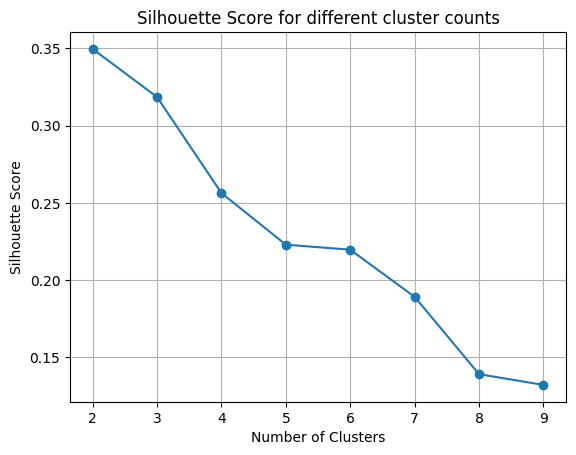

In [12]:
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np

range_n_clusters = range(2, 10)
sil_scores = []

X = bow_matrix.toarray()

for n in range_n_clusters:
    km = KMeans(n_clusters=n, random_state=42)
    km.fit(X)
    score = silhouette_score(X, km.labels_)
    sil_scores.append(score)

plt.plot(range_n_clusters, sil_scores, marker="o")
plt.title("Silhouette Score for different cluster counts")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()
